In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/Users/zionwang/opt/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
PATH = "Data/"


In [4]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False)

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
display_all(df_raw.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [7]:
df_raw.set_index(['PassengerId','Survived']).count(level="Survived")

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,
0,549,549,549,424,549,549,549,549,68,549
1,342,342,342,290,342,342,342,342,136,340


In [8]:
df_raw = df_raw.drop(columns = ['Name'])

In [9]:
display_all(df_raw.describe(include='all'))

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [10]:
train_cats(df_raw)

In [11]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Age            0.198653
Cabin          0.771044
Embarked       0.002245
Fare           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.000000
Ticket         0.000000
dtype: float64

In [12]:
df, y, nas = proc_df(df_raw, 'Survived')

In [13]:
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,2,35.0,0,0,473,8.0500,0,3,False


In [14]:
?proc_df

In [15]:
# imports for HPO
from hyperopt import hp
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import Trials
from collections import OrderedDict
from sklearn.metrics import roc_auc_score

In [16]:
space = OrderedDict([('n_estimators', hp.choice('n_estimators', [20,50,100,200,500])),
                     ('max_features', hp.uniform('max_features', 0.1, 1.0)),
                     ('min_samples_leaf', hp.choice('min_samples_leaf', [1,2,3,5,8,13,21]))
                    ])

In [17]:
def objective(params):
    """Objective function to minimize"""

    m = RandomForestClassifier(n_jobs=-1, **params)
    m.fit(X_train, y_train)
    predictions = m.predict_proba(X_valid)

    return -(roc_auc_score(y_valid, predictions[:,1]))

In [18]:
?roc_auc_score

In [59]:
# re-run this cell only if want to reset HPO
trials = Trials()

In [60]:
tpe_best = None

tpe_best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=150)
tpe_best

100%|██████████| 150/150 [01:00<00:00,  2.50trial/s, best loss: -0.9294685990338164]


{'max_features': 0.9791563483072641, 'min_samples_leaf': 4, 'n_estimators': 1}

In [25]:
m = RandomForestRegressor(max_features = .522351, min_samples_leaf = 1)
m.fit(X_train, y_train)
print_score(m)

[0.1383624931950189, 0.35853791738426666, 0.9196248335893498, 0.4378246514837818]


In [20]:
draw_tree(m.estimators_[0], df, precision=3)

NameError: name 'm' is not defined

In [21]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9194461173425367

In [55]:
?RandomForestRegressor

In [21]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 178
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((713, 11), (713,), (178, 11))

In [22]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [26]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 264 ms, sys: 39 ms, total: 303 ms
Wall time: 144 ms
[0.14277700617496544, 0.41079533710689076, 0.9144142089093702, 0.26200634920634924]


In [28]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.14100470981759206, 0.4009840423847201, 0.9165257808499745, 0.29683734989648036]


In [27]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.]),
 0.45,
 0)

In [28]:
preds.shape

(100, 178)

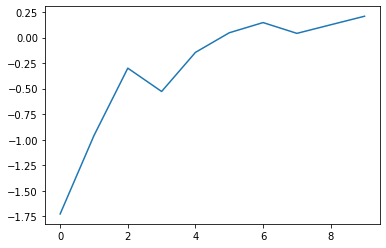

In [29]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [30]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
2,Sex,0.293892
0,PassengerId,0.140482
6,Ticket,0.139453
3,Age,0.118080
7,Fare,0.112373
1,Pclass,0.078588
8,Cabin,0.054973
4,SibSp,0.024402
9,Embarked,0.019191
5,Parch,0.011686


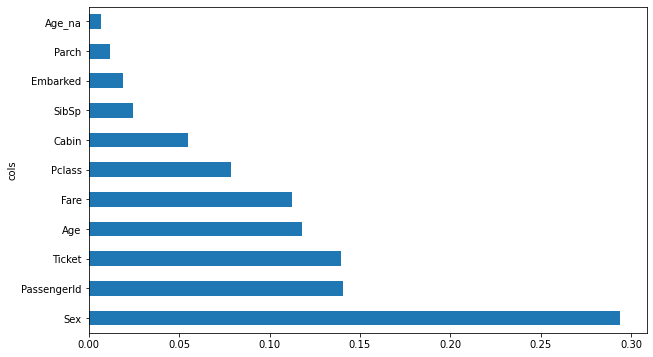

In [31]:
fi.plot.barh('cols', 'imp', figsize=(10,6), legend=False);

In [32]:
from scipy.cluster import hierarchy as hc

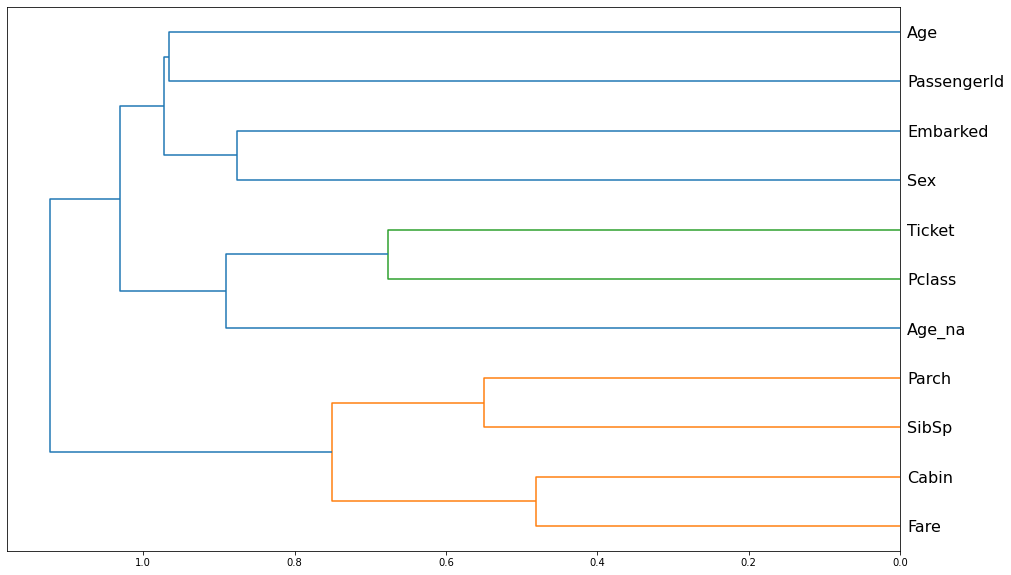

In [33]:
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

In [34]:
display_all(df_raw.describe(include='all'))

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [35]:
df_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [36]:
df_test = df_test.drop(columns = ['Name'])

In [37]:
train_cats(df_raw)

In [38]:
df2, x, nas2 = proc_df(df_test, 'Survived')

KeyError: 'Survived'

In [39]:
display_all(df_test.describe(include='all'))

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [40]:
df_ext = df.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/Users/zionwang/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9988776655443322

In [42]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,PassengerId,0.972966
6,Ticket,0.007429
3,Age,0.006656
7,Fare,0.005982
8,Cabin,0.001906
4,SibSp,0.001481
5,Parch,0.001331
9,Embarked,0.001184
2,Sex,0.000580
1,Pclass,0.000486


In [43]:
x.drop('PassengerId', axis=1, inplace=True)

In [44]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.7912457912457912

In [45]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
5,Ticket,0.314230
2,Age,0.238934
6,Fare,0.222834
7,Cabin,0.059598
1,Sex,0.040082
3,SibSp,0.035163
4,Parch,0.026720
8,Embarked,0.023697
0,Pclass,0.022890
9,Age_na,0.015852


In [46]:
feats = ['PassengerId', 'Ticket', 'Age', 'Fare', 'Cabin']

In [47]:
for f in feats:
    df_subs = df.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

PassengerId
[0.2548836335495305, 0.3132842301259268, 0.7272473201698683, 0.5707812521374989, 0.4117589127745429]
Ticket
[0.2567294443343904, 0.3373737756727936, 0.7232825871890356, 0.5022351127689131, 0.38971579077979224]
Age
[0.25706573619745554, 0.3417829571446904, 0.7225571638694813, 0.4891393861903197, 0.3796865192691582]
Fare
[0.25456392883449164, 0.33487249723638374, 0.7279311273502225, 0.5095885782307059, 0.378325881832953]
Cabin
[0.2473360637117247, 0.32791735446392367, 0.743161564046309, 0.5297482526699142, 0.41004153503518215]


In [48]:
df_subs = df.drop('PassengerId', axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(min_samples_leaf=1, max_features=0.522, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13586200820498823, 0.32255998484037773, 0.9225036610343061, 0.5449882677708764, 0.4250064591586331]


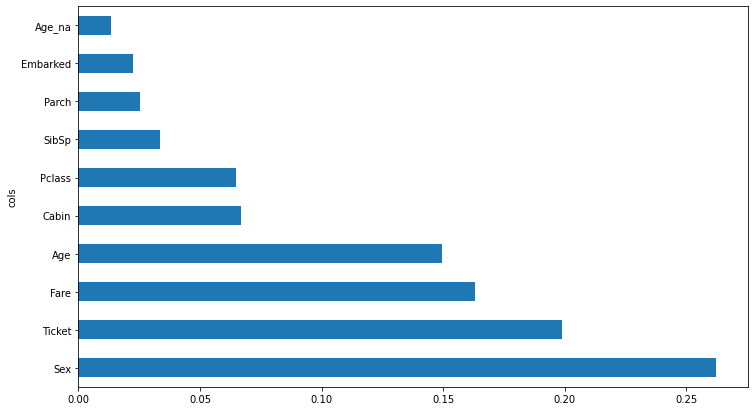

In [51]:
plot_fi(rf_feat_importance(m, X_train));

In [63]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [65]:
df_raw2 = pd.read_csv(f'{PATH}Train.csv', low_memory=False)

In [71]:
df_raw2 = df_raw2.drop(columns = ['Name'])

In [70]:
df_raw2 = df_raw2.drop(columns = ['PassengerId'])

In [66]:
df_raw2['Age'] = df_raw2['Age'].fillna(-1)

In [67]:
df_raw2['Age_na'] = 0

In [68]:
for index, row in df_raw2.iterrows():
    if row['Age'] == -1:
        df_raw2.at[row['PassengerId'], 'Age_na'] = 1

In [69]:
display_all(df_raw2.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-1.0,1,2,W./C. 6607,23.45,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,0
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0


In [72]:
train_cats(df_raw2)

In [73]:
df, y, nas = proc_df(df_raw2, 'Survived')

In [74]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 178
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((713, 10), (713,), (178, 10))

In [75]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [78]:
m = RandomForestRegressor(max_features = 0.5677241434195215, min_samples_leaf = 1,  n_estimators = 1)
m.fit(X_train, y_train)
print_score(m)

[0.280252340711105, 0.5192907868894986, 0.6702508960573477, -0.1792960662525882]


In [79]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.1412323044309154, 0.3298305659686364, 0.9162560931899641, 0.5242449413388544]


In [14]:
display_all(df_raw2.describe(include='all'))

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
count,891.000000,891.000000,891,891.000000,891.000000,891.000000,891,891.000000,204,889,891.0
unique,NaN,NaN,2,NaN,NaN,NaN,681,NaN,147,3,NaN
top,NaN,NaN,male,NaN,NaN,NaN,1601,NaN,B96 B98,S,NaN
freq,NaN,NaN,577,NaN,NaN,NaN,7,NaN,4,644,NaN
mean,0.383838,2.308642,NaN,23.600640,0.523008,0.381594,NaN,32.204208,NaN,NaN,0.0
std,0.486592,0.836071,NaN,17.867496,1.102743,0.806057,NaN,49.693429,NaN,NaN,0.0
min,0.000000,1.000000,NaN,-1.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.0
25%,0.000000,2.000000,NaN,6.000000,0.000000,0.000000,NaN,7.910400,NaN,NaN,0.0
50%,0.000000,3.000000,NaN,24.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,0.0
75%,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,0.0


In [80]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
1,Sex,0.294188
5,Ticket,0.204291
6,Fare,0.147299
2,Age,0.144563
0,Pclass,0.080420
7,Cabin,0.060566
3,SibSp,0.023959
4,Parch,0.020753
8,Embarked,0.017940
9,Age_na,0.006021


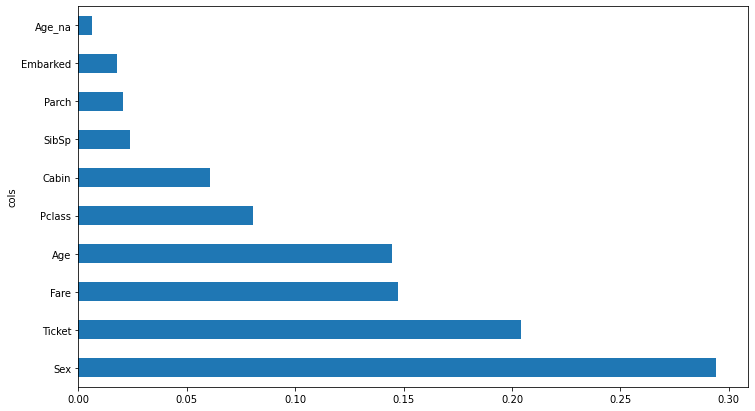

In [81]:
plot_fi(rf_feat_importance(m, X_train));

<AxesSubplot:>

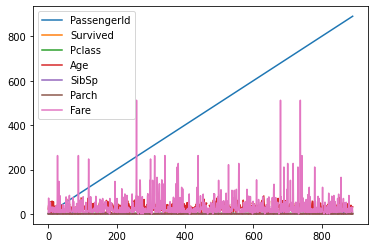

In [82]:
df_raw.plot()

<AxesSubplot:xlabel='Age', ylabel='Survived'>

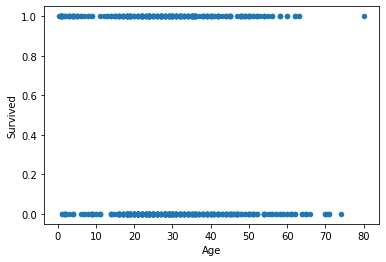

In [83]:
df_raw.plot.scatter(x = 'Age',
                   y = 'Survived')

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

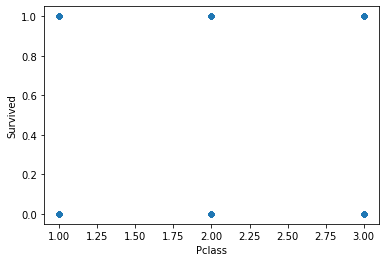

In [84]:
df_raw.plot.scatter(x = 'Pclass',
                   y = 'Survived')

In [85]:
df_raw.set_index(['PassengerId','Pclass']).count(level='Pclass')

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pclass,,,,,,,,,
1,216,216,186,216,216,216,216,176,214
2,184,184,173,184,184,184,184,16,184
3,491,491,355,491,491,491,491,12,491


In [86]:
df_raw.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


In [87]:
df_raw2.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare,Age_na
Survived,,,,,,
0,2.531876,23.425319,0.553734,0.329690,22.117887,0.025501
1,1.950292,23.882076,0.473684,0.464912,48.395408,0.032164


In [43]:
df_raw3 = pd.read_csv(f'{PATH}Train.csv', low_memory=False)

In [45]:
display_all(df_raw3.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [46]:
df_raw3['Last Name'] = ""
df_raw3['Title'] = ""

In [48]:
display_all(df_raw3.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,Title
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,,
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,,
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,,
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,,
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,,


In [49]:
for index, row in df_raw3.iterrows():
    tempname = str(row['Name'])
    com = tempname.find(',')
    per = tempname.find('.')
    temp1 = tempname[0:com]
    temp2 = tempname[(com+1):per]
    df_raw3.at[row['PassengerId']-1, 'Last Name'] = temp1
    df_raw3.at[row['PassengerId']-1, 'Title'] = temp2

In [50]:
display_all(df_raw3.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,Title
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,Montvila,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,Graham,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,Johnston,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,Behr,Mr
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,Dooley,Mr


In [51]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Age            0.198653
Cabin          0.771044
Embarked       0.002245
Fare           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.000000
Ticket         0.000000
dtype: float64

In [27]:
df_raw3['Last Name'] = df_raw3['Last Name'].fillna('p')
df_raw3['Title'] = df_raw3['Title'].fillna('x')

In [28]:
display_all(df_raw3.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,Title
887,888.0,1.0,1.0,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.00,B42,S,Montvila,Rev
888,889.0,0.0,3.0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1.0,2.0,W./C. 6607,23.45,NaN,S,Graham,Miss
889,890.0,1.0,1.0,"Behr, Mr. Karl Howell",male,26.0,0.0,0.0,111369,30.00,C148,C,Johnston,Miss
890,891.0,0.0,3.0,"Dooley, Mr. Patrick",male,32.0,0.0,0.0,370376,7.75,NaN,Q,Behr,Mr
891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dooley,Mr


In [52]:
df_raw3 = df_raw3.drop(columns = ['Name'])
df_raw3 = df_raw3.drop(columns = ['PassengerId'])

In [53]:
train_cats(df_raw3)

In [54]:
df, y, nas = proc_df(df_raw3, 'Survived')

In [55]:
display_all(df.tail())

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,Title,Age_na
886,2,2,27.0,0,0,102,13.00,0,3,407,15,False
887,1,1,19.0,0,0,15,30.00,31,3,222,9,False
888,3,1,28.0,1,2,676,23.45,0,3,294,9,True
889,1,2,26.0,0,0,9,30.00,61,1,53,12,False
890,3,2,32.0,0,0,467,7.75,0,2,160,12,False


In [79]:
lastnames = df_raw3.groupby(['Last Name'])['Last Name'].count()
#display_all(lastnames)
display_all(lastnames.sort_values(ascending = False))

Last Name
Andersson                 9
Sage                      7
Skoog                     6
Johnson                   6
Panula                    6
Goodwin                   6
Carter                    6
Rice                      5
Hart                      4
Harris                    4
Smith                     4
Williams                  4
Harper                    4
Palsson                   4
Lefebre                   4
Baclini                   4
Asplund                   4
Fortune                   4
Brown                     4
Gustafsson                4
Ford                      4
Kelly                     4
Davies                    3
Moran                     3
Laroche                   3
Van Impe                  3
Taussig                   3
Goldsmith                 3
Thayer                    3
Jussila                   3
Hickman                   3
Vander Planke             3
O'Brien                   3
Newell                    3
Collyer                   3
Meyer     

In [58]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 270 ms, sys: 40 ms, total: 310 ms
Wall time: 149 ms
[0.1351457578933865, 0.33318601613560345, 0.9233186123911931, 0.5145157487922705]


In [61]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
1,Sex,0.295765
9,Last Name,0.147691
5,Ticket,0.143299
6,Fare,0.109864
2,Age,0.098692
0,Pclass,0.075713
7,Cabin,0.052363
3,SibSp,0.025761
10,Title,0.020991
8,Embarked,0.017260


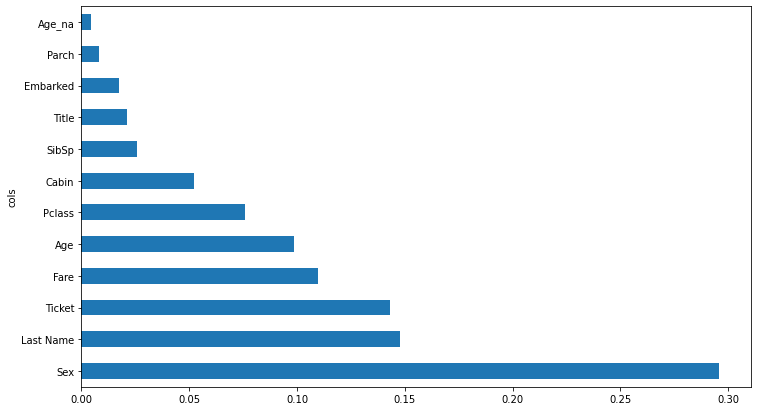

In [64]:
plot_fi(rf_feat_importance(m, X_train));

In [56]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 178
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw3, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((713, 12), (713,), (178, 12))

In [57]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [4]:
?train_cats

In [66]:
os.makedirs('tmp', exist_ok=True)
df_raw3.to_feather('tmp/Titanic_raw')